In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL
import scipy
from IPython.display import clear_output as clr
%matplotlib inline

In [2]:
# Defining data directory
data_dir = os.getcwd() + '/../'
# Check in contents of current dir are same as expected
os.listdir(data_dir)

['.ipynb_checkpoints',
 '20news-18828.tar.gz',
 'corpuses',
 'LDA',
 'stackoverflow-data-idf.json',
 'stackoverflow-test.json',
 'TF-IDF',
 'train_corpus',
 'Unigram']

In [3]:
from nltk.corpus import brown
 
data = []
 
for fileid in brown.fileids():
    document = ' '.join(brown.words(fileid))
    data.append(document)

In [4]:
len(data)

500

In [5]:
class vocab:
    
    def __init__(self, corpus):
        """
        Corpus : list of docs
        """
        self.dictionary = {}
        self.vocab_size = 0
        self.make_vocab(corpus)
        self.inv_dictionary = {v: k for k, v in self.dictionary.items()}
    
    def make_vocab(self,corpus):
        
        count = 0
        for doc in corpus:
            for word in doc.strip().split():
                if(word in self.dictionary.keys()):
                    pass
                else:
                    self.dictionary[word] = count
                    count += 1
        
        self.vocab_size = count
        assert(len(self.dictionary.keys()) == count), "Wrong Number of words added"
        
    def get_index(self,word):
        if(word in self.dictionary.keys()):
            return self.dictionary[word]
        else:
            return -1
    
    def get_word(self,index):
        if(index in self.inv_dictionary.keys()):
            return self.inv_dictionary[index]
        else:
            return " "

In [6]:
myDict = vocab(data)

In [7]:
myDict.vocab_size

56057

In [9]:
class LDA:
    
    def __init__(self,vocab, K):
        """
        vocab : a dictionary class containing all the words and corresponding indices
        k : smoothing parameter for beta matrix
        """
        self.eps = 10e-8
        self.tol = 0.001
        self.vocab = vocab
        self.V = vocab.vocab_size
        self.K = K
        self.alpha = np.zeros((self.K, 1)) + np.random.rand()
        beta = np.random.rand(self.K, self.V)
        beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
        self.beta = beta
        
        self.gamma = np.random.rand(self.K , 1)
        self.digamma = scipy.special.digamma
        self.polygamma = scipy.special.polygamma
        
        
    def train(self, corpus, epochs = 1):
        
        """
        Corpus : List of documents
        epochs : max_number of epochs
        """
        
        
        M = len(corpus)
        
        for epoch in range(epochs):
            
            beta = np.zeros((self.K, self.V))
            grad_alpha = 0*self.alpha
            hesn_alpha = np.zeros((self.K, self.K))
            print("Initialized")
            count = 0
            
            for doc in corpus:
                clr(wait = True)
                count += 1
                print("epoch : ", epoch, " doc init: ", count)
                words = doc.strip().split(" ")
                N = len(words)
                phi = np.zeros((N, self.K)) + 1/self.K
                gamma = self.alpha + N/self.K
                w = np.zeros((N, self.V))
                

                new_norm = self.norm(gamma)
                old_norm = new_norm  + 20
                while(np.abs(new_norm - old_norm) > self.tol):
                    for j, word in enumerate(words):
                        
                        index = self.vocab.get_index(word)
                        beta_v = (self.beta[:,index].reshape(self.K, 1))
                        phi_n = self.calc_phi(beta_v, gamma)
                        phi[j, :] = phi_n.reshape(-1)
                        w[j, index] = 1

                    gamma = self.alpha + np.sum(phi , axis = 0).reshape(self.K, 1)
                    old_norm = new_norm
                    new_norm = self.norm(gamma)


                print("epoch : ", epoch, "made gamma and phi converge ", count)
                

                beta = beta+np.dot(phi.T, w)
                
                        
                print("epoch : ", epoch, "made beta", count)

                
                grad_alpha += self.digamma(np.sum(self.alpha)) - self.digamma(self.alpha)
                grad_alpha += self.digamma(gamma) - self.digamma(np.sum(gamma))

                
            beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
            alpha = self.alpha
            hess_alpha = np.diag(M*scipy.special.polygamma(1,alpha).reshape(-1)) - scipy.special.polygamma(1,np.sum(alpha))
            alpha += np.dot(np.linalg.inv(hess_alpha),grad_alpha.reshape(-1,1))            


            # update params
            self.beta = beta
            self.gamma = gamma
            self.alpha = alpha
            

    def calc_phi(self, beta_v, gamma):
        phi = np.exp(self.digamma(gamma) - self.digamma(np.sum(gamma))).reshape(self.K,1)
        phi = beta_v*phi
        phi = phi/(np.sum(phi, axis = 0) + self.eps)
        return phi
    
    def norm(self, a):
        sqr = np.square(a)
        return np.sqrt(np.sum(sqr))

In [10]:
model = LDA(myDict , 50)

In [24]:
model.train(data, epochs= 10)

epoch :  0  doc init:  1


KeyboardInterrupt: 

In [29]:
indices = np.argsort(model.beta[44])[0:10]

In [30]:
for i in indices:
    print(myDict.get_word(i))

Disneyland
six-man
snubbed
efficiently
longitude
excusable
demarcated
injected
Initial
Appropriation


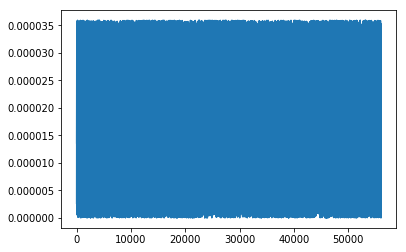

In [32]:
plt.plot(model.beta[0])
plt.show()

In [11]:
class Smooth_LDA:
    
    def __init__(self,vocab, K):
        """
        vocab : a dictionary class containing all the words and corresponding indices
        k : smoothing parameter for beta matrix
        """
        self.eps = 10e-8
        self.tol = 0.001
        self.vocab = vocab
        self.V = vocab.vocab_size
        self.K = K
        self.alpha = np.zeros((self.K, 1)) + np.random.rand()
        beta = np.random.rand(self.K, self.V)
        beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
        self.beta = beta
        
        self.ita = 1/self.V
        self.lamda = self.ita*np.ones((self.K,self.V))
        
        self.gamma = np.random.rand(self.K , 1)
        self.digamma = scipy.special.digamma
        self.polygamma = scipy.special.polygamma
        
        
    def train(self, corpus, epochs = 1):
        
        """
        Corpus : List of documents
        epochs : max_number of epochs
        """
        
        
        M = len(corpus)
        
        for epoch in range(epochs):
            
            beta = np.zeros((self.K, self.V))
            grad_alpha = 0*self.alpha
            hesn_alpha = np.zeros((self.K, self.K))
            print("Initialized")
            count = 0
            
            for doc in corpus:
                clr(wait = True)
                count += 1
                print("epoch : ", epoch, " doc init: ", count)
                words = doc.strip().split(" ")
                N = len(words)
                phi = np.zeros((N, self.K)) + 1/self.K
                gamma = self.alpha + N/self.K
                w = np.zeros((N, self.V))
                

                new_norm = self.norm(gamma)
                old_norm = new_norm  + 20
                while(np.abs(new_norm - old_norm) > self.tol):
                    for j, word in enumerate(words):
                        
                        index = self.vocab.get_index(word)
                        beta_v = (self.beta[:,index].reshape(self.K, 1))
                        phi_n = self.calc_phi(beta_v, gamma)
                        phi[j, :] = phi_n.reshape(-1)
                        w[j, index] = 1

                    gamma = self.alpha + np.sum(phi , axis = 0).reshape(self.K, 1)
                    old_norm = new_norm
                    new_norm = self.norm(gamma)


                print("epoch : ", epoch, "made gamma and phi converge ", count)
                beta = beta+np.dot(phi.T, w)
                
                        
                print("epoch : ", epoch, "made beta", count)

                
                grad_alpha += self.digamma(np.sum(self.alpha)) - self.digamma(self.alpha)
                grad_alpha += self.digamma(gamma) - self.digamma(np.sum(gamma))
                

            lamda = self.ita + beta
            beta = np.exp(self.digamma(lamda)- self.digamma(np.sum(lamda,axis = 1))) ;
            beta = beta/(np.sum(beta,  axis = 1).reshape(-1,1) + self.eps)
            
            alpha = self.alpha
            hess_alpha = np.diag(M*scipy.special.polygamma(1,alpha).reshape(-1)) - scipy.special.polygamma(1,np.sum(alpha))
            alpha += np.dot(np.linalg.inv(hess_alpha),grad_alpha.reshape(-1,1))
            
            # update params
            self.beta = beta
            self.gamma = gamma
            self.alpha = alpha
            self.lamda = lamda
            

    def calc_phi(self, beta_v, gamma):
        phi = np.exp(self.digamma(gamma) - self.digamma(np.sum(gamma))).reshape(self.K,1)
        phi = beta_v*phi
        phi = phi/(np.sum(phi, axis = 0) + self.eps)
        return phi
    
    def norm(self, a):
        sqr = np.square(a)
        return np.sqrt(np.sum(sqr))

In [15]:
s_model = Smooth_LDA(myDict , 50)

In [ ]:
s_model.train(data, epochs= 5)

epoch :  0  doc init:  97


In [ ]:
indices = np.argsort(model.beta[44])[0:10]

In [ ]:
for i in indices:
    print(myDict.get_word(i))

In [ ]:
plt.plot(model.beta[44])
plt.show()